In [1]:
from networkit import *
from matplotlib import pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
%matplotlib inline

In [2]:
#Configuration
ego = 708
sparsificationAlgorithm = sparsification.LocalDegreeBackbone()

In [3]:
#Utility functions
def showHideEdges(_graph, _visibleAttributeCurrent, _visibleAttributeTarget):
    added = 0
    removed = 0
    for (x,y) in _graph.edges():
        edgeId = _graph.edgeId(x,y)
        if _visibleAttributeTarget[edgeId] > _visibleAttributeCurrent[edgeId]:
            client.exportAdditionalEdge(x,y)
            added = added + 1
        elif _visibleAttributeTarget[edgeId] < _visibleAttributeCurrent[edgeId]:
            client.removeExportedEdge(x,y)
            removed = removed + 1
        _visibleAttributeCurrent[edgeId] = _visibleAttributeTarget[edgeId]
    #print(added, " added, ", removed, " removed")

In [4]:
#Preparations
client = gephi.streaming.GephiStreamingClient()
G = readGraph("/home/gerd/workspace/NetworKit-glindner/scripts/SparsificationEvaluation/input/Caltech36.graphml", Format.GraphML)
G.indexEdges()

G_empty = Graph(G.upperNodeIdBound() + 1)
client.exportGraph(G)

In [5]:
sparsificationAttribute = sparsificationAlgorithm.getAttribute(G)
labels = [n for n in G.nodes()]
client.exportNodeValues(G, labels, 'Label')
visibleAttributeCurrent = [1 for e in G.edges()]
triangleCounter = sparsification.ChibaNishizekiTriangleCounter(G)
triangles = triangleCounter.getAttribute()

In [6]:
def getEgoTriangleAttribute(originalGraph, sparsifiedGraph, ego):
    _triangleAttribute = [0 for x in G.edges()]
    for v in originalGraph.neighbors(ego):
        for u in originalGraph.neighbors(v):
            if sparsifiedGraph.hasEdge(u, ego):
                _triangleAttribute[originalGraph.edgeId(ego, v)] = 1
                _triangleAttribute[originalGraph.edgeId(u, v)] = 1
                _triangleAttribute[originalGraph.edgeId(ego, u)] = 1
    return _triangleAttribute

In [7]:
def highlightEgoTriangleEdges(originalGraph, sparsifiedGraph, ego, _visibleAttributeCurrent):
    egoTriangleAttribute = getEgoTriangleAttribute(originalGraph, sparsifiedGraph, ego)
    showHideEdges(originalGraph, _visibleAttributeCurrent, egoTriangleAttribute)

In [8]:
def highlightHubNodes(originalGraph, sparsifiedGraph, ego):
    ccs = properties.ClusteringCoefficient.exactLocal(sparsifiedGraph)
    label = list(map(lambda x: (str(x) + "{:10.2f}".format(ccs[x])) if ccs[x] > 0.1 else "", originalGraph.nodes()))
    size = list(map(lambda x: originalGraph.degree(x) * 0.1, originalGraph.nodes()))
    client.exportNodeValues(originalGraph, label, 'Label')
    client.exportNodeValues(originalGraph, size, 'size')
    print("Ego has a local CC of ", ccs[ego])
    
    r = [0] * G.numberOfNodes()
    g = [0] * G.numberOfNodes()
    b = [0] * G.numberOfNodes()
    b[ego] = 1.0
    client.exportNodeValues(G, r, 'r')
    client.exportNodeValues(G, g, 'g')
    client.exportNodeValues(G, b, 'b')

In [9]:
def setRatio(originalGraph, ego, ratio, _visibleAttributeCurrent):
    S = sparsificationAlgorithm.getSparsifiedGraphOfSize(originalGraph, ratio, sparsificationAttribute)
    
    highlightHubNodes(originalGraph, S, ego)
    highlightEgoTriangleEdges(originalGraph, S, ego, _visibleAttributeCurrent)
        
    print('avg cc original: ', properties.ClusteringCoefficient.avgLocal(originalGraph))
    print('avg cc sparsified: ', properties.ClusteringCoefficient.avgLocal(S))

In [10]:
setRatio(G, ego, 1.0, visibleAttributeCurrent)

Ego has a local CC of  0.12736711505811676
avg cc original:  0.42881115297424743
avg cc sparsified:  0.41519731418513833


##### "Animation": only the edges to neighbors that are connected to ego by triangles are show; with decreasing edge ratio.

In [291]:
ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]
for ratio in ratios:
    clear_output()
    print(ratio, ":")
    setRatio(G, ego, ratio, visibleAttributeCurrent)
    sys.stdout.flush()
    time.sleep(1)

0.01 :
Ego has a local CC of  0.0
avg cc original:  0.42881115297424743
avg cc sparsified:  0.0


###### Plots of local clustering coefficients

In [11]:
def getCCs(r):
    return properties.ClusteringCoefficient.exactLocal(sparsificationAlgorithm.getSparsifiedGraphOfSize(G, r, sparsificationAttribute))

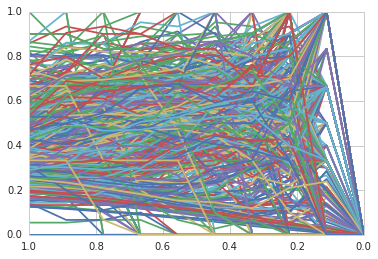

In [17]:
#plot development of the local ccs
ns = G.nodes()#[ego]
ratios = np.linspace(1.0, 0.0, 10)
plt.gca().invert_xaxis()
ccLists = [[] for n in G.nodes()] #list of ccs for each node

for r in ratios:
    ccs = getCCs(r)
    for n in ns:
        ccLists[n].append(ccs[n])
        
ccs = getCCs(1.0)
for n in ns:
    if ccs[n] >= 0.0 and ccs[n] <= 1.0:
        plt.plot(ratios, ccLists[n])

##### Old stuff...

In [2]:
G = readGraph("/home/gerd/workspace/NetworKit-glindner/scripts/SparsificationEvaluation/input/us-aviation-t100-2013.graphml", Format.GraphML)
G.indexEdges()

identified graph as weighted


In [20]:
gc = gephi.streaming.GephiStreamingClient()
gc.exportGraph(G)

In [21]:
sparsificationAlgorithm = sparsification.LocalDegreeBackbone()

In [22]:
ldAttribute = sparsificationAlgorithm.getAttribute(G)

In [23]:
gc.exportEdgeValues(G, ldAttribute, 'lda')

Let's consider the first n edges that get removed from the graph during sparsification.

In [24]:
def exportNodeColors(colors):
    gc.exportNodeValues(G, list(map(lambda c: c[0], colors)), 'r')
    gc.exportNodeValues(G, list(map(lambda c: c[1], colors)), 'g')
    gc.exportNodeValues(G, list(map(lambda c: c[2], colors)), 'b')

In [25]:
def normalizeVector(inputVector):
    return [v/max(inputVector) for v in inputVector]

In [26]:
colors = [(0,0,0)] * G.upperNodeIdBound()
ldRank = sparsification.getRankAttribute(ldAttribute, False)
for (a,b) in G.edges():
    edgeId = G.edgeId(a, b)
    if ldRank[edgeId] < 10:
        colors[a] = (1.0,0,0)
        colors[b] = (1.0,0,0)
exportNodeColors(colors)
gc.exportNodeValues(G, [5] * G.upperNodeIdBound(), 'size')

In [28]:
exactLocals = normalizeVector(properties.ClusteringCoefficient.exactLocal(G))
#print(exactLocals)
exportNodeColors([(c,0.0,0.0) for c in exactLocals])